In [1]:
import MDAnalysis
from MDAnalysis import Universe
from MDAnalysis.analysis.hydrogenbonds.hbond_analysis import HydrogenBondAnalysis as HBA
import MDAnalysis.analysis.lineardensity as ld
from MDAnalysis.lib.log import ProgressBar
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import MDAnalysis.transformations
from MDAnalysis import Writer
from MDAnalysis.analysis.density import DensityAnalysis
from scipy import linalg
import pandas as pd
# import nglview as nv
from mpl_toolkits.axes_grid1 import make_axes_locatable

/opt/rh/rh-python38/root/usr/local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# %matplotlib inline

In [3]:
def calc_R(xc, yc,x,y):
    """ calculate the distance of each 2D points from the center (xc, yc) """
    return np.sqrt((x-xc)**2 + (y-yc)**2)

In [4]:
font = {'family': 'serif',
        'weight': 'normal',
        'size': 20,
        }
matplotlib.rc('font', **font)

In [5]:
def algmeth(xdp,ydp,xhi):
    """algebraic method"""
    x=xdp[ydp>xhi]
    y=ydp[ydp>xhi]

    # coordinates of the barycenter
    x_m = np.mean(x)
    y_m = np.mean(y)

    # calculation of the reduced coordinates
    u = x - x_m
    v = y - y_m

    # linear system defining the center (uc, vc) in reduced coordinates:
    #    Suu * uc +  Suv * vc = (Suuu + Suvv)/2
    #    Suv * uc +  Svv * vc = (Suuv + Svvv)/2
    Suv  = np.sum(u*v)
    Suu  = np.sum(u**2)
    Svv  = np.sum(v**2)
    Suuv = np.sum(u**2 * v)
    Suvv = np.sum(u * v**2)
    Suuu = np.sum(u**3)
    Svvv = np.sum(v**3)

    # Solving the linear system
    A = np.array([ [ Suu, Suv ], [Suv, Svv]])
    B = np.array([ Suuu + Suvv, Svvv + Suuv ])/2.0
    uc, vc = linalg.solve(A, B)

    xc_1 = x_m + uc
    yc_1 = y_m + vc

    # Calcul des distances au centre (xc_1, yc_1)
    Ri_1     = np.sqrt((x-xc_1)**2 + (y-yc_1)**2)
    R_1      = np.mean(Ri_1)
    residu_1 = np.sum((Ri_1-R_1)**2)
    return xc_1,yc_1,R_1

In [6]:
def scipleastsq(xdp,ydp,xhi):
    """scipy least squares method"""
    x=xdp[ydp>xhi]
    y=ydp[ydp>xhi]

    # coordinates of the barycenter
    x_m = np.mean(x)
    y_m = np.mean(y)

    #  == METHOD 2 ==
    from scipy      import optimize
#     from math import sqrt

#     method_2 = "leastsq"

#     def calc_R(xc, yc):
#         """ calculate the distance of each 2D points from the center (xc, yc) """
#         return np.sqrt((x-xc)**2 + (y-yc)**2)

    def f_2(c):
        """ calculate the algebraic distance between the data points and the mean circle centered at c=(xc, yc) """
        Ri = calc_R(*c)
        return Ri - Ri.mean()

    center_estimate = x_m, y_m
    center_2, ier = optimize.leastsq(f_2, center_estimate)

    xc_2, yc_2 = center_2
    Ri_2       = calc_R(*center_2)
    R_2        = Ri_2.mean()
    residu_2   = sum((Ri_2 - R_2)**2)
    return xc_2,yc_2,R_2

In [7]:
def odrmeth(xdp,ydp,xhi):
    """ODR method"""
    x=xdp[ydp>xhi]
    y=ydp[ydp>xhi]

    # coordinates of the barycenter
    x_m = np.mean(x)
    y_m = np.mean(y)

    # == METHOD 3 ==
    from scipy      import  odr

    method_3 = "odr"

    def f_3(beta, x):
        """ implicit definition of the circle """
        return (x[0]-beta[0])**2 + (x[1]-beta[1])**2 -beta[2]**2

    # initial guess for parameters
    R_m = calc_R(x_m, y_m,x,y).mean()
    beta0 = [ x_m, y_m, R_m]

    # for implicit function :
    #       data.x contains both coordinates of the points (data.x = [x, y])
    #       data.y is the dimensionality of the response
    lsc_data  = odr.Data(np.row_stack([x, y]), y=1)
    lsc_model = odr.Model(f_3, implicit=True)
    lsc_odr   = odr.ODR(lsc_data, lsc_model, beta0)
    lsc_out   = lsc_odr.run()

    xc_3, yc_3, R_3 = lsc_out.beta
    Ri_3 = calc_R(xc_3, yc_3,x,y)
    residu_3 = sum((Ri_3 - R_3)**2)
    return xc_3,yc_3,R_3 

In [8]:
def get_ca(datafile,trjfile,delta=0.5,start=1):
    """calculate left and right contact angle of cilindrical droplet"""
    # define universe, drop selection, center trajectory, grid to use and run density analysis
    u=Universe(datafile,trjfile, format="LAMMPSDUMP",dt=0.001)
    drop=u.select_atoms('type 12 13')
    notdrop=u.select_atoms('not type 12 13')
    allatoms=u.select_atoms('all')
    box=u.dimensions[:3]
    workflow=[MDAnalysis.transformations.unwrap(drop),MDAnalysis.transformations.center_in_box(drop,center='geometry',wrap=False)]
    u.trajectory.add_transformations(*workflow)
    
    drop_d=DensityAnalysis(drop,delta=delta,gridcenter=box/2,xdim=box[0],ydim=box[1],zdim=box[2])
    drop_d.run(start=start,verbose=True)
    # center of drop to get the bulk density value
    xc,zc=int(np.round(box[0]/2)/delta),int(np.round(box[2]/2)/delta)
    # get a small sample from the middle of the drop, 10 Angstrom
    w=int(10/delta)
    # dm is the bulk density divided by two, our criterion to locate the l-v interface
    dm=drop_d.results.density.grid[xc-w:xc+w,:,zc-w:zc+w].mean()/2
#     dm=0.04
    # xlo is lowest z coordinate of the droplet, our defintion of the surface location
    # xlo=np.argmax(drop_d.results.density.grid[:,:,:].mean(axis=(0,1)).T)
#     xlo=np.nonzero(drop_d.results.density.grid[:,:,:].mean(axis=(0,1)).T)[0][0]
    xlo=np.where(drop_d.results.density.grid[:,:,:].mean(axis=(0,1))>1e-3)[0][0]
    # 10 Angstrom of the xlo is the place where we gonna consider for the fitting
    xhi=xlo+10/delta
    # copy of 3d density:
    dca=drop_d.results.density.grid[:,:,:].mean(axis=(1))
    # remove values greater than 10% of dm
    dcacuthi=np.where(dca<dm*1.1,dca,0)
    # remove values smaller than 10% of dm
    dcacutlo=np.where(dca>dm*0.9,dcacuthi,0)
    # just assigning as another name
    dcaf=dcacutlo
    # makes all values !=0 equal to 1
    dcaf1=np.where(dcaf!=0,dcaf,1)
    # put values in x and y variables
    xdp,ydp=np.where(dcaf1!=1)
    # fitting with algebraic method
    xc_1,yc_1,R_1=algmeth(xdp,ydp,xhi)
    # putting the results of fitting in a nice way
    theta_fit = np.linspace(-np.pi, np.pi, 180)
    x_fit1 = xc_1 + R_1*np.cos(theta_fit)
    y_fit1 = yc_1 + R_1*np.sin(theta_fit)
    # just assigning another variable for xlo
    hsurf=xlo
    # getting the fitted values only above hsurf
    xl,yl=xr,yr=x_fit1[y_fit1>hsurf],y_fit1[y_fit1>hsurf]
    # sorting the left side of the drop correctly
    xl,yl=xl[xl<xc],yl[xl<xc]
    xl,yl=xl[np.argsort(yl)],yl[np.argsort(yl)]
    # sorting the right side of the drop correctly
    xr,yr=xr[xr>xc],yr[xr>xc]
    xr,yr=xr[np.argsort(yr)],yr[np.argsort(yr)]
    # finally the ca values
    cal=np.degrees(np.arctan((yl[1]-yl[0])/(xl[1]-xl[0])))
    car=np.degrees(np.arctan((yr[1]-yr[0])/(xr[1]-xr[0])))
    if cal<0 and car>0:
        cal+=180
        car=180-car
    elif cal>0 and car<0:
        cal=cal
        car=-car
    else:
        print("Something is wrong with the ca's")
    return cal,car,x_fit1,y_fit1,drop_d.results.density.grid[:,:,:],box,hsurf

In [9]:
def just_dens(datafile,trjfile,delta=0.5,start=1):
    """calculate left and right contact angle of cilindrical droplet"""
    # define universe, drop selection, center trajectory, grid to use and run density analysis
    u=Universe(datafile,trjfile, format="LAMMPSDUMP",dt=0.001)
    drop=u.select_atoms('type 12 13')
    notdrop=u.select_atoms('not type 12 13')
    allatoms=u.select_atoms('all')
    box=u.dimensions[:3]
    workflow=[MDAnalysis.transformations.unwrap(drop),MDAnalysis.transformations.center_in_box(drop,center='geometry',wrap=False)]
    u.trajectory.add_transformations(*workflow)
    
    drop_d=DensityAnalysis(drop,delta=delta,gridcenter=box/2,xdim=box[0],ydim=box[1],zdim=box[2])
    drop_d.run(start=start,verbose=True)
    
    return drop_d.results.density,box

In [10]:
# cal_3789,car_3780,x_fit_3780,y_fit_3780,dropgrid_3780,box_3780,hsurf_3780=get_ca("drop_3780/nvt.data","drop_3780/nvt.dcd",1,start=1)

In [11]:
# ddrop5154,box5154=just_dens("d_5154/test.data","d_5154/nvt.lammpstrj",1,start=1001)

In [12]:
cal5154,car5154,x_fit5154,y_fit5154,dropgrid5154,box5154,hsurf5154=get_ca("d_5154/test.data","d_5154/nvt.lammpstrj",1,start=1001)

/users/moraisja/.local/lib/python3.8/site-packages/MDAnalysis/analysis/density.py:422: UserWarning: Box padding (currently set at 2.0) is not used in user defined grids.
  warnings.warn(msg)
100%|██████████| 1000/1000 [01:21<00:00, 12.26it/s]


In [13]:
cal5871,car5871,x_fit5871,y_fit5871,dropgrid5871,box5871,hsurf5871=get_ca("d_5871/test.data","d_5871/nvt.lammpstrj",1,start=1001)

100%|██████████| 1000/1000 [02:46<00:00,  6.00it/s]


In [14]:
cal6561,car6561,x_fit6561,y_fit6561,dropgrid6561,box6561,hsurf6561=get_ca("d_6561/test.data","d_6561/nvt.lammpstrj",1,start=1001)

100%|██████████| 1000/1000 [01:29<00:00, 11.21it/s]


In [15]:
cal7320,car7320,x_fit7320,y_fit7320,dropgrid7320,box7320,hsurf7320=get_ca("d_7320/test.data","d_7320/nvt.lammpstrj",1,start=1001)

100%|██████████| 1000/1000 [01:33<00:00, 10.73it/s]


In [16]:
cal8082,car8082,x_fit8082,y_fit8082,dropgrid8082,box8082,hsurf8082=get_ca("d_8082/test.data","d_8082/nvt.lammpstrj",1,start=1001)

100%|██████████| 1000/1000 [01:39<00:00, 10.08it/s]


In [17]:
cal8922,car8922,x_fit8922,y_fit8922,dropgrid8922,box8922,hsurf8922=get_ca("d_8922/test.data","d_8922/nvt.lammpstrj",1,start=1001)

100%|██████████| 1000/1000 [01:45<00:00,  9.48it/s]


In [18]:
cal9696,car9696,x_fit9696,y_fit9696,dropgrid9696,box9696,hsurf9696=get_ca("d_9696/test.data","d_9696/nvt.lammpstrj",1,start=1001)

100%|██████████| 1000/1000 [01:57<00:00,  8.51it/s]


In [10]:
cal10479,car10479,x_fit10479,y_fit10479,dropgrid10479,box10479,hsurf10479=get_ca("d_10479/test.data","d_10479/nvt.lammpstrj",1,start=1001)

/users/moraisja/.local/lib/python3.8/site-packages/MDAnalysis/analysis/density.py:422: UserWarning: Box padding (currently set at 2.0) is not used in user defined grids.
  warnings.warn(msg)
100%|██████████| 1000/1000 [01:59<00:00,  8.39it/s]


In [20]:
cal11319,car11319,x_fit11319,y_fit11319,dropgrid11319,box11319,hsurf11319=get_ca("d_11319/test.data","d_11319/nvt.lammpstrj",1,start=1001)

100%|██████████| 1000/1000 [02:03<00:00,  8.12it/s]


In [21]:
cal12063,car12063,x_fit12063,y_fit12063,dropgrid12063,box12063,hsurf12063=get_ca("d_12063/test.data","d_12063/nvt.lammpstrj",1,start=1001)

100%|██████████| 1000/1000 [02:09<00:00,  7.73it/s]


In [22]:
cal12822,car12822,x_fit12822,y_fit12822,dropgrid12822,box12822,hsurf12822=get_ca("d_12822/test.data","d_12822/nvt.lammpstrj",1,start=1001)

100%|██████████| 1000/1000 [02:14<00:00,  7.42it/s]


In [23]:
cal13596,car13596,x_fit13596,y_fit13596,dropgrid13596,box13596,hsurf13596=get_ca("d_13596/test.data","d_13596/nvt.lammpstrj",1,start=1001)

100%|██████████| 745/745 [01:44<00:00,  7.14it/s]


40.72625698323999 41.731843575419255


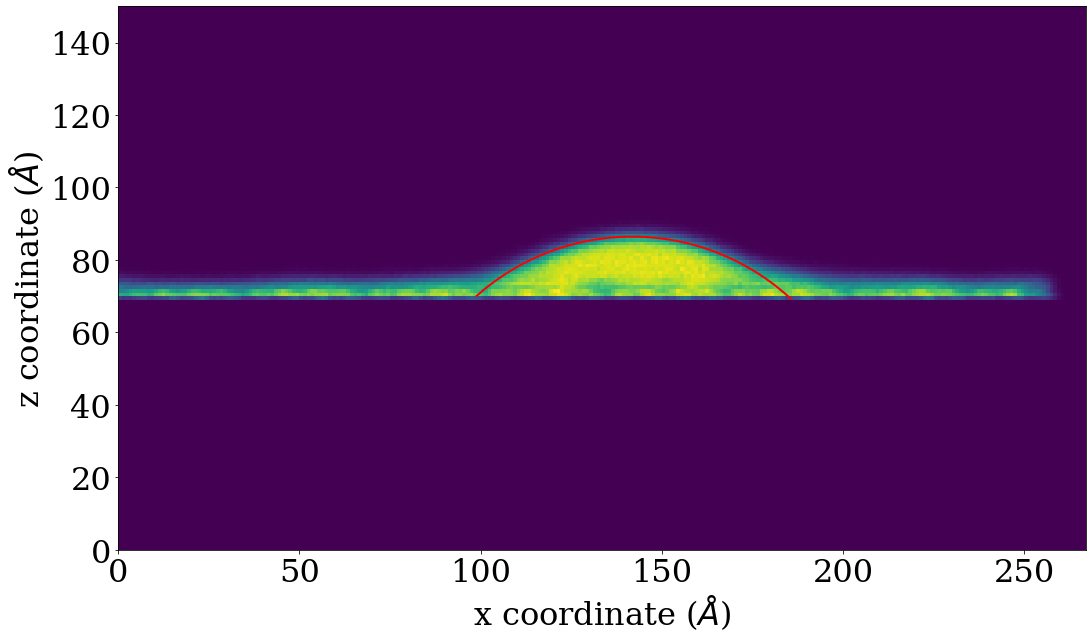

In [53]:
plt.figure(figsize=(20,10))
plt.imshow(dropgrid5154.mean(axis=1).T,origin='lower',cmap='viridis',extent=[0,box5154[0],0,box5154[2]]) #,vmax=0.1)
# plt.colorbar()
plt.plot(x_fit5154[y_fit5154>hsurf5154], y_fit5154[y_fit5154>hsurf5154] ,'r', label='fit', lw=2)
# plt.plot(x_fit1, y_fit1 ,'.r', label='fit', lw=1)
plt.xlabel('x coordinate ($\AA$)')
plt.ylabel('z coordinate ($\AA$)')
print(cal5154,car5154)

32.68156424581007 31.67597765363128


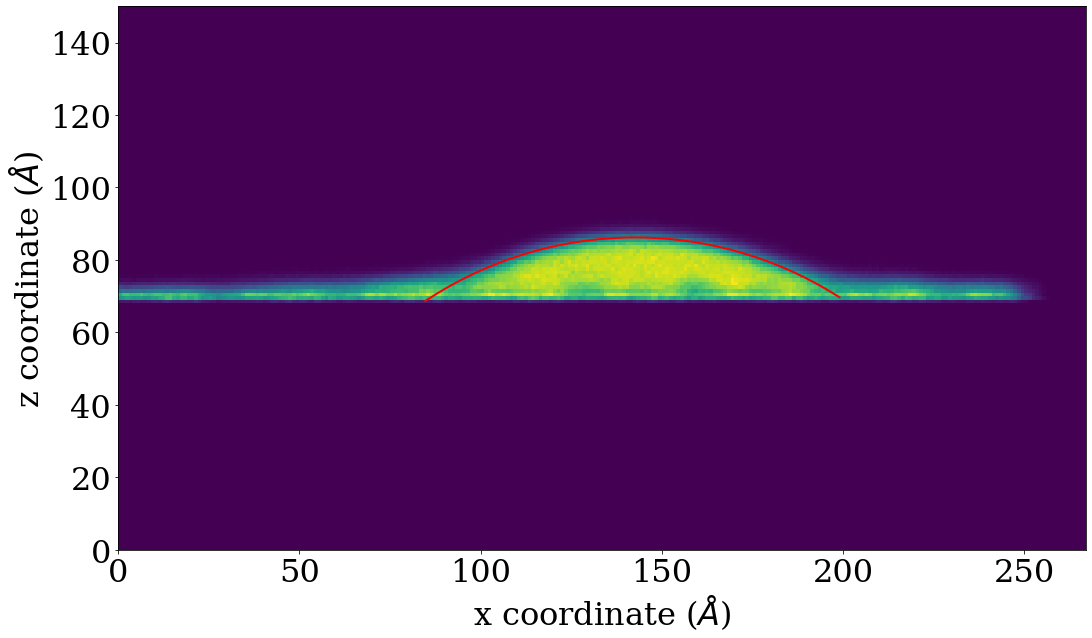

In [54]:
plt.figure(figsize=(20,10))
plt.imshow(dropgrid5871.mean(axis=1).T,origin='lower',cmap='viridis',extent=[0,box5871[0],0,box5871[2]]) #,vmax=0.1)
# plt.colorbar()
plt.plot(x_fit5871[y_fit5871>hsurf5871], y_fit5871[y_fit5871>hsurf5871] ,'r', label='fit', lw=2)
# plt.plot(x_fit1, y_fit1 ,'.r', label='fit', lw=1)
plt.xlabel('x coordinate ($\AA$)')
plt.ylabel('z coordinate ($\AA$)')
print(cal5871,car5871)

34.69273743016749 35.69832402234633


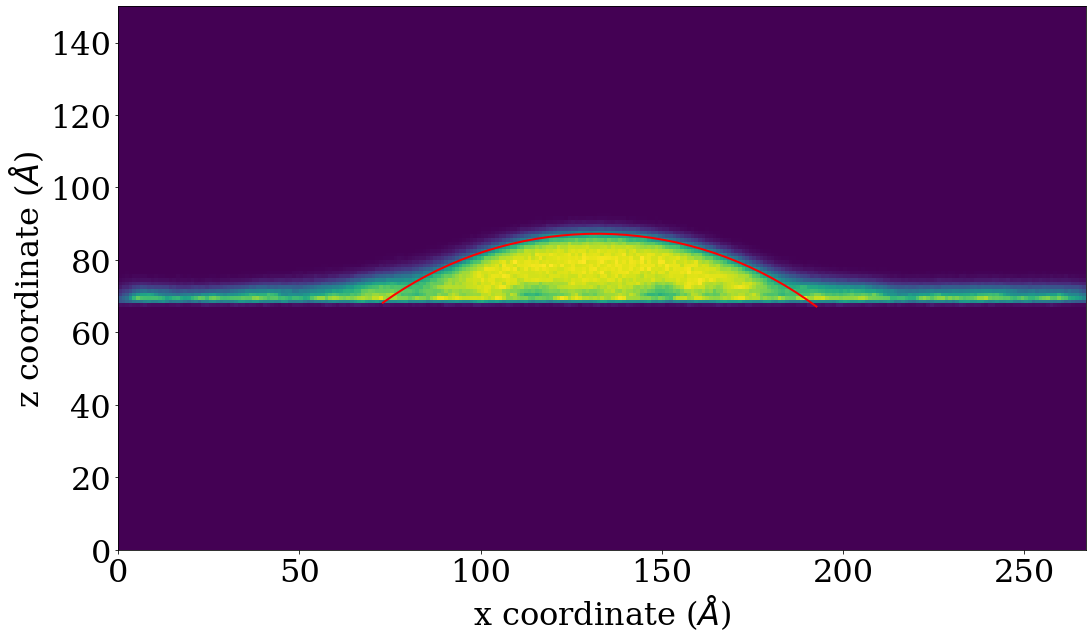

In [55]:
plt.figure(figsize=(20,10))
plt.imshow(dropgrid6561.mean(axis=1).T,origin='lower',cmap='viridis',extent=[0,box6561[0],0,box6561[2]]) #,vmax=0.1)
# plt.colorbar()
plt.plot(x_fit6561[y_fit6561>hsurf6561], y_fit6561[y_fit6561>hsurf6561] ,'r', label='fit', lw=2)
# plt.plot(x_fit1, y_fit1 ,'.r', label='fit', lw=1)
plt.xlabel('x coordinate ($\AA$)')
plt.ylabel('z coordinate ($\AA$)')
print(cal6561,car6561)

36.703910614525014 37.709497206703894


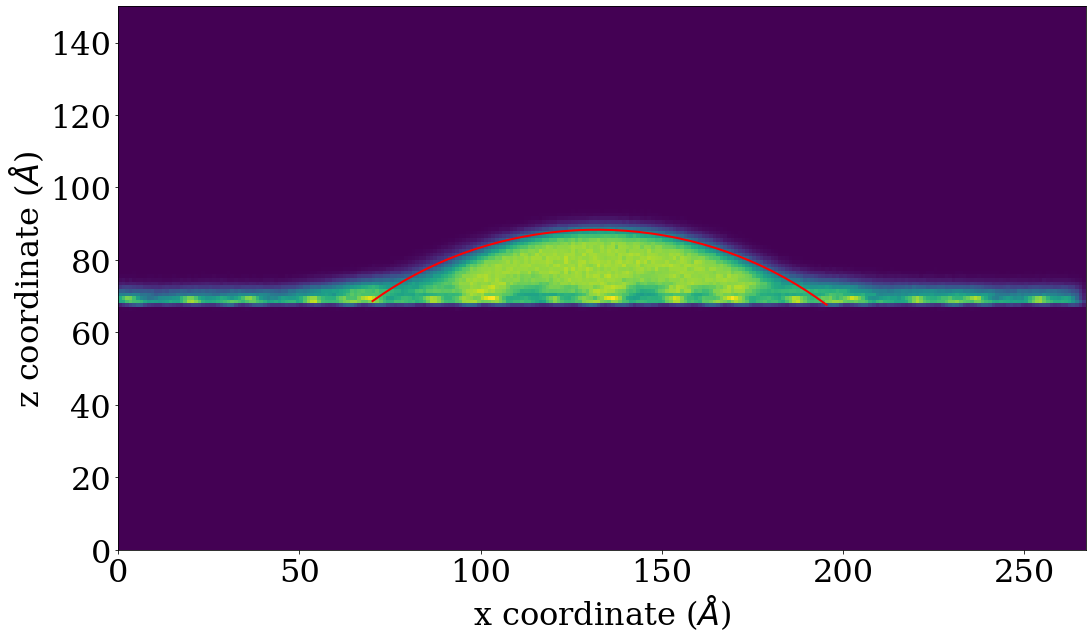

In [56]:
plt.figure(figsize=(20,10))
plt.imshow(dropgrid7320.mean(axis=1).T,origin='lower',cmap='viridis',extent=[0,box7320[0],0,box7320[2]]) #,vmax=0.1)
# plt.colorbar()
plt.plot(x_fit6561[y_fit7320>hsurf7320], y_fit7320[y_fit7320>hsurf7320] ,'r', label='fit', lw=2)
# plt.plot(x_fit1, y_fit1 ,'.r', label='fit', lw=1)
plt.xlabel('x coordinate ($\AA$)')
plt.ylabel('z coordinate ($\AA$)')
print(cal7320,car7320)

32.681564245810115 33.6871508379886


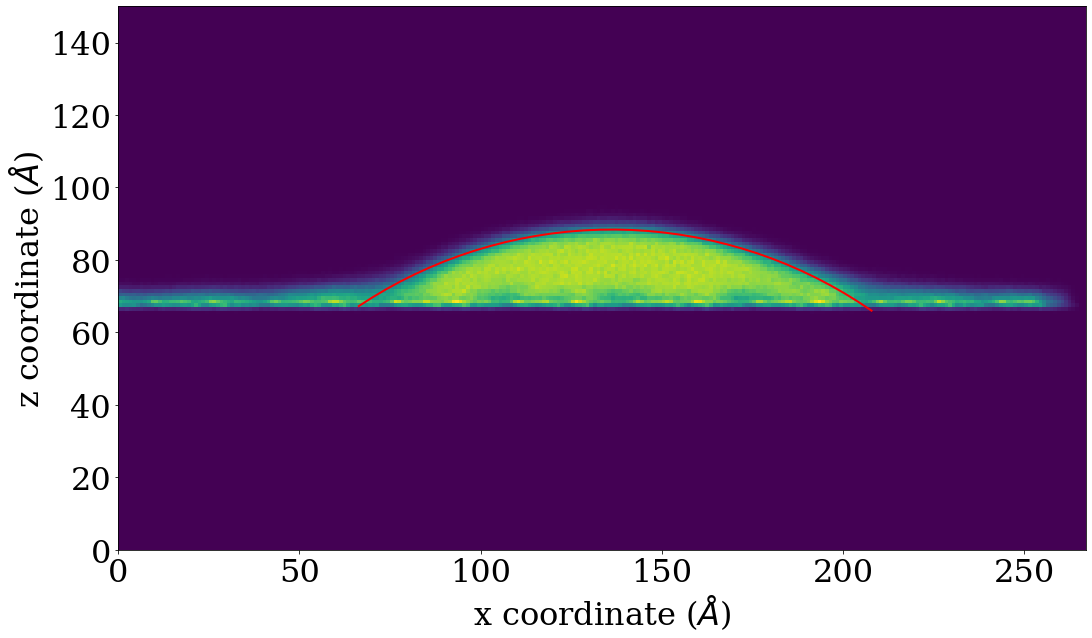

In [57]:
plt.figure(figsize=(20,10))
plt.imshow(dropgrid8082.mean(axis=1).T,origin='lower',cmap='viridis',extent=[0,box8082[0],0,box8082[2]]) #,vmax=0.1)
# plt.colorbar()
plt.plot(x_fit8082[y_fit8082>hsurf8082], y_fit8082[y_fit8082>hsurf8082] ,'r', label='fit', lw=2)
# plt.plot(x_fit1, y_fit1 ,'.r', label='fit', lw=1)
plt.xlabel('x coordinate ($\AA$)')
plt.ylabel('z coordinate ($\AA$)')
print(cal8082,car8082)

34.692737430167654 33.68715083798853


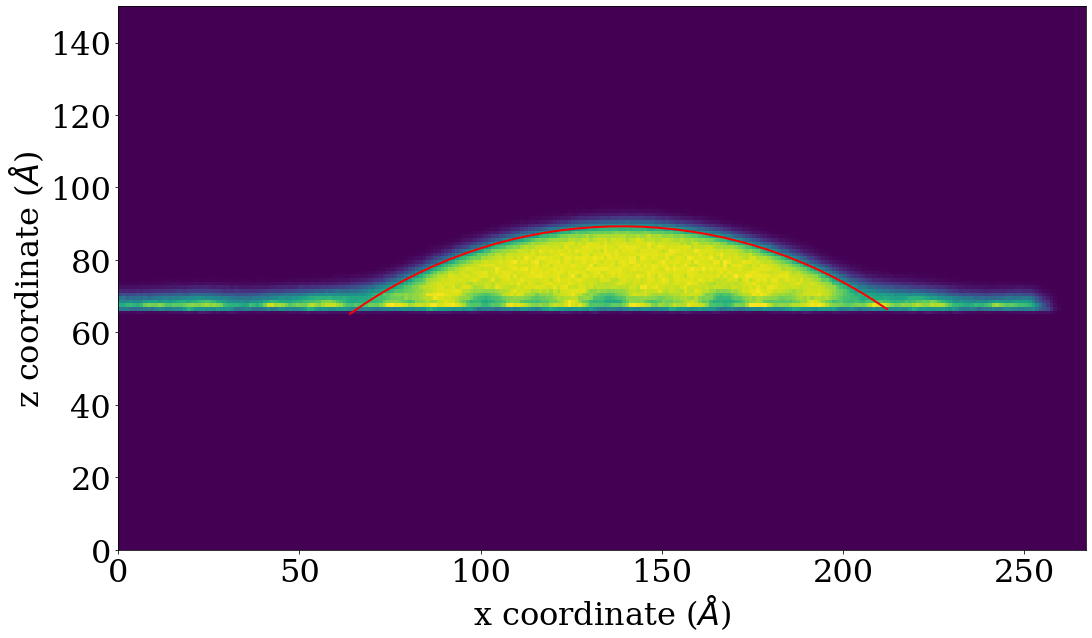

In [58]:
plt.figure(figsize=(20,10))
plt.imshow(dropgrid8922.mean(axis=1).T,origin='lower',cmap='viridis',extent=[0,box8922[0],0,box8922[2]]) #,vmax=0.1)
# plt.colorbar()
plt.plot(x_fit8922[y_fit8922>hsurf8922], y_fit8922[y_fit8922>hsurf8922] ,'r', label='fit', lw=2)
# plt.plot(x_fit1, y_fit1 ,'.r', label='fit', lw=1)
plt.xlabel('x coordinate ($\AA$)')
plt.ylabel('z coordinate ($\AA$)')
print(cal8922,car8922)

34.692737430167504 35.69832402234633


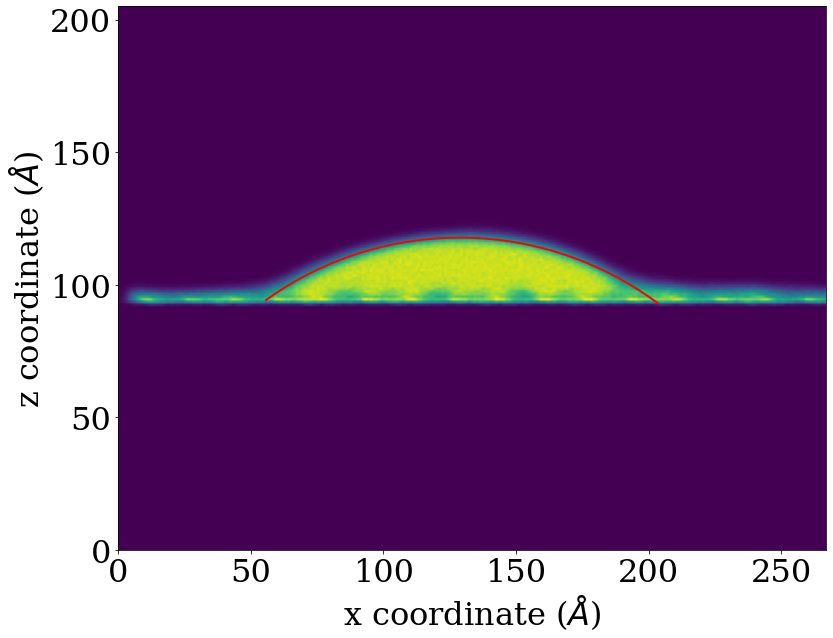

In [59]:
plt.figure(figsize=(20,10))
plt.imshow(dropgrid9696.mean(axis=1).T,origin='lower',cmap='viridis',extent=[0,box9696[0],0,box9696[2]]) #,vmax=0.1)
# plt.colorbar()
plt.plot(x_fit9696[y_fit9696>hsurf9696], y_fit9696[y_fit9696>hsurf9696] ,'r', label='fit', lw=2)
# plt.plot(x_fit1, y_fit1 ,'.r', label='fit', lw=1)
plt.xlabel('x coordinate ($\AA$)')
plt.ylabel('z coordinate ($\AA$)')
print(cal9696,car9696)

32.68156424581 31.67597765363122


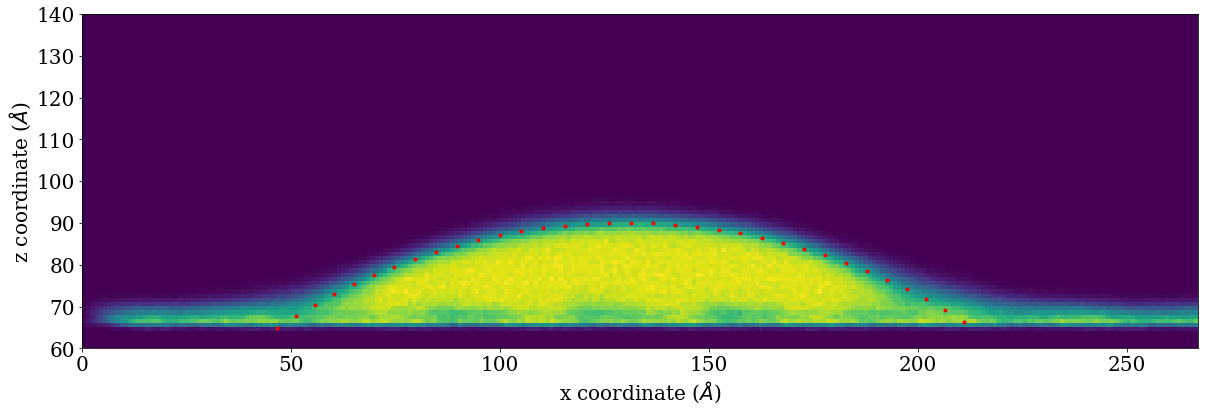

In [14]:
plt.figure(figsize=(20,10))
plt.imshow(dropgrid10479.mean(axis=1).T,origin='lower',cmap='viridis',extent=[0,box10479[0],0,box10479[2]]) #,vmax=0.1)
# plt.colorbar()
plt.plot(x_fit10479[y_fit10479>hsurf10479], y_fit10479[y_fit10479>hsurf10479] ,'r.', label='fit', lw=2,markersize=6)
# plt.plot(x_fit1, y_fit1 ,'.r', label='fit', lw=1)
plt.xlabel('x coordinate ($\AA$)')
plt.ylabel('z coordinate ($\AA$)')
print(cal10479,car10479)
plt.ylim(60,140)
# plt.savefig('c3_10479.png',dpi=600)
plt.savefig('c3_10479.svg')

In [61]:
(cal10479+car10479)/2

32.178770949720615

36.70391061452502 37.70949720670396


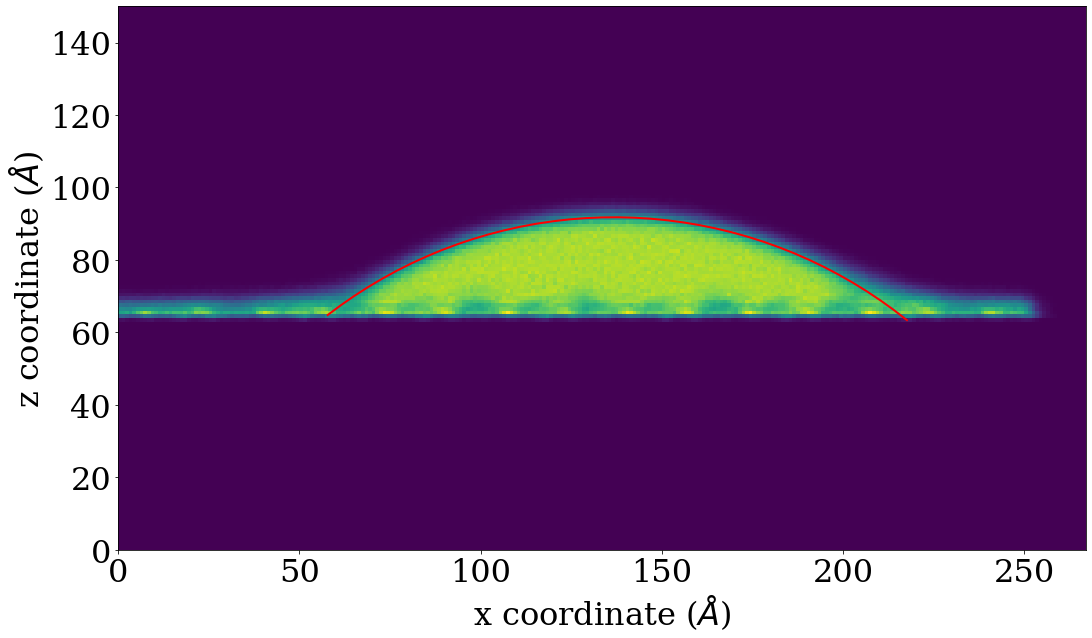

In [62]:
plt.figure(figsize=(20,10))
plt.imshow(dropgrid11319.mean(axis=1).T,origin='lower',cmap='viridis',extent=[0,box11319[0],0,box11319[2]]) #,vmax=0.1)
# plt.colorbar()
plt.plot(x_fit11319[y_fit11319>hsurf11319], y_fit11319[y_fit11319>hsurf11319] ,'r', label='fit', lw=2)
# plt.plot(x_fit1, y_fit1 ,'.r', label='fit', lw=1)
plt.xlabel('x coordinate ($\AA$)')
plt.ylabel('z coordinate ($\AA$)')
print(cal11319,car11319)

32.681564245810215 33.68715083798845


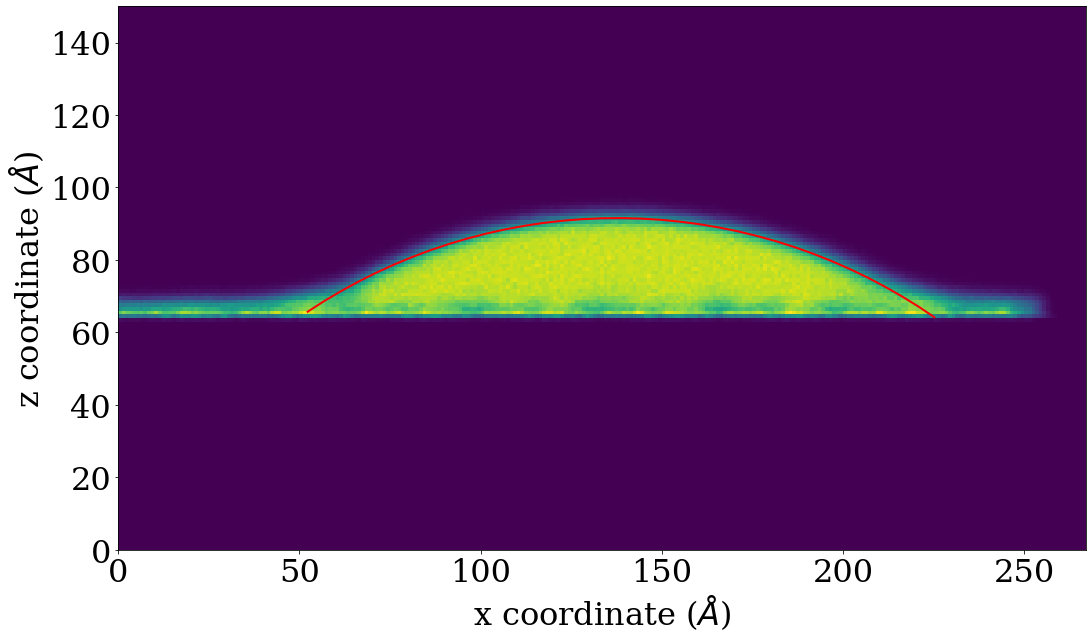

In [63]:
plt.figure(figsize=(20,10))
plt.imshow(dropgrid12063.mean(axis=1).T,origin='lower',cmap='viridis',extent=[0,box12063[0],0,box12063[2]]) #,vmax=0.1)
# plt.colorbar()
plt.plot(x_fit12063[y_fit12063>hsurf12063], y_fit12063[y_fit12063>hsurf12063] ,'r', label='fit', lw=2)
# plt.plot(x_fit1, y_fit1 ,'.r', label='fit', lw=1)
plt.xlabel('x coordinate ($\AA$)')
plt.ylabel('z coordinate ($\AA$)')
print(cal12063,car12063)

32.68156424581019 33.68715083798858
179.24897597955075


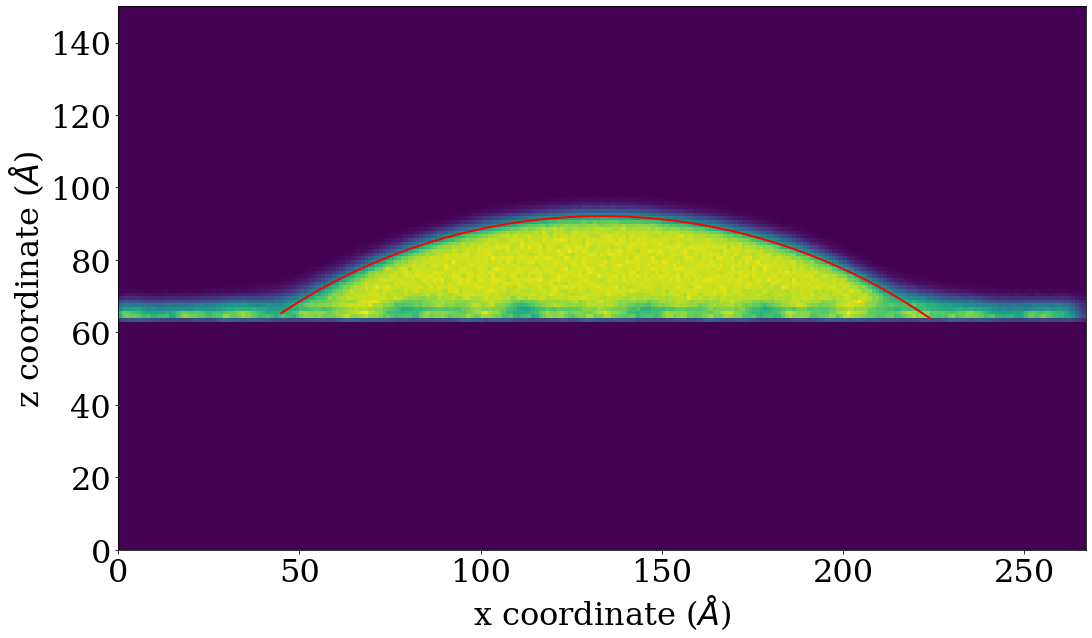

In [64]:
plt.figure(figsize=(20,10))
plt.imshow(dropgrid12822.mean(axis=1).T,origin='lower',cmap='viridis',extent=[0,box12822[0],0,box12822[2]]) #,vmax=0.1)
# plt.colorbar()
plt.plot(x_fit12822[y_fit12822>hsurf12822], y_fit12822[y_fit12822>hsurf12822] ,'r', label='fit', lw=2)
# plt.plot(x_fit1, y_fit1 ,'.r', label='fit', lw=1)
plt.xlabel('x coordinate ($\AA$)')
plt.ylabel('z coordinate ($\AA$)')
print(cal12822,car12822)
print(x_fit12822[y_fit12822>hsurf12822][0]-x_fit12822[y_fit12822>hsurf12822][-1])

36.70391061452499 37.709497206703816


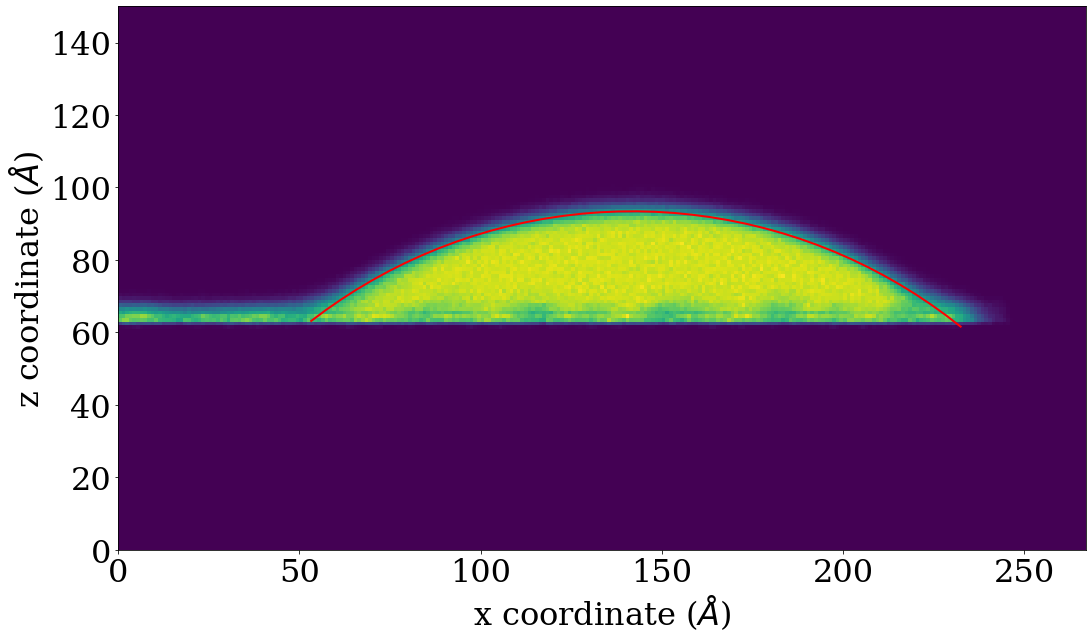

In [65]:
plt.figure(figsize=(20,10))
plt.imshow(dropgrid13596.mean(axis=1).T,origin='lower',cmap='viridis',extent=[0,box13596[0],0,box13596[2]]) #,vmax=0.1)
# plt.colorbar()
plt.plot(x_fit13596[y_fit13596>hsurf13596], y_fit13596[y_fit13596>hsurf13596] ,'r', label='fit', lw=2)
# plt.plot(x_fit1, y_fit1 ,'.r', label='fit', lw=1)
plt.xlabel('x coordinate ($\AA$)')
plt.ylabel('z coordinate ($\AA$)')
print(cal13596,car13596)